# Contrastive Financial Embeddings

## Context
Off-the-shelf text embeddings (NB02) capture general semantics but aren't optimized for financial signal. Contrastive learning fine-tunes embeddings so that texts about stocks with similar returns are close together, and texts about diverging stocks are far apart.

## My Experience
At Creyon Bio, I used contrastive learning to predict oligo toxicity from 3D electrostatic maps, pushing AUC from 0.73 to 0.88. Same framework applies here: learn a representation where the downstream signal (stock returns) is encoded in embedding similarity.

## Pipeline
Financial headlines + stock returns → Contrastive pairs (same return quintile = positive, different = negative) → Fine-tune encoder → Financial-signal-optimized embeddings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

## 1. Create Training Data
We need (headline, stock_return) pairs. The contrastive loss will learn embeddings where stocks with similar returns have similar headline embeddings.

In [2]:
# Synthetic dataset: headlines with associated stock returns
# In production: real headlines from news APIs + real returns from market data
np.random.seed(42)

data = []
# Generate headlines with implicit sentiment → return correlation
templates_positive = [
    "{company} reports record quarterly revenue exceeding analyst expectations",
    "{company} announces major partnership deal to expand market reach",
    "{company} beats earnings estimates by wide margin in Q4",
    "{company} raises full-year guidance citing strong demand",
    "{company} wins major government contract worth $2 billion",
    "{company} launches innovative product to strong customer reception",
    "{company} expands into new markets with strategic acquisition",
    "{company} reports surge in subscriber growth beating all estimates",
]
templates_negative = [
    "{company} misses revenue expectations amid weakening demand",
    "{company} announces layoffs affecting 10% of workforce",
    "{company} faces regulatory investigation over business practices",
    "{company} warns of lower guidance citing supply chain issues",
    "{company} reports unexpected quarterly loss shocking analysts",
    "{company} recalls products due to safety concerns",
    "{company} loses market share to competitors in core business",
    "{company} under pressure as key customers reduce orders",
]
templates_neutral = [
    "{company} reports quarterly results in line with expectations",
    "{company} maintains steady operations in challenging environment",
    "{company} announces leadership transition as CEO retires",
    "{company} completes previously announced restructuring plan",
]

companies = [
    "Acme Corp",
    "Beta Inc",
    "Gamma Tech",
    "Delta Health",
    "Epsilon Energy",
    "Zeta Finance",
    "Eta Retail",
    "Theta Pharma",
    "Iota Systems",
    "Kappa Media",
    "Lambda Auto",
    "Mu Logistics",
    "Nu Biotech",
    "Xi Mining",
    "Omicron Telecom",
]

for company in companies:
    # Positive headlines → higher returns
    for template in np.random.choice(templates_positive, size=3, replace=False):
        ret = np.random.normal(0.05, 0.02)  # positive return
        data.append({
            "company": company,
            "headline": template.format(company=company),
            "return": ret,
            "quintile": None,
        })
    # Negative headlines → lower returns
    for template in np.random.choice(templates_negative, size=3, replace=False):
        ret = np.random.normal(-0.05, 0.02)
        data.append({
            "company": company,
            "headline": template.format(company=company),
            "return": ret,
            "quintile": None,
        })
    # Neutral headlines → near-zero returns
    for template in np.random.choice(templates_neutral, size=2, replace=False):
        ret = np.random.normal(0.0, 0.02)
        data.append({
            "company": company,
            "headline": template.format(company=company),
            "return": ret,
            "quintile": None,
        })

df = pd.DataFrame(data)
# Assign quintiles based on returns
df["quintile"] = pd.qcut(df["return"], q=5, labels=[0, 1, 2, 3, 4]).astype(int)

print(f"Dataset: {len(df)} headlines, {df['company'].nunique()} companies")
print(f"\nReturn distribution by quintile:")
print(df.groupby("quintile")["return"].agg(["mean", "std", "count"]).to_string())

Dataset: 120 headlines, 15 companies

Return distribution by quintile:
              mean       std  count
quintile                           
0        -0.065690  0.011900     24
1        -0.034066  0.008145     24
2         0.004237  0.010839     24
3         0.034606  0.007875     24
4         0.063262  0.011297     24


## 2. Baseline: Off-the-Shelf Embeddings
Before fine-tuning, see how well vanilla embeddings cluster by return quintile.

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Baseline embedding shape: (120, 384)


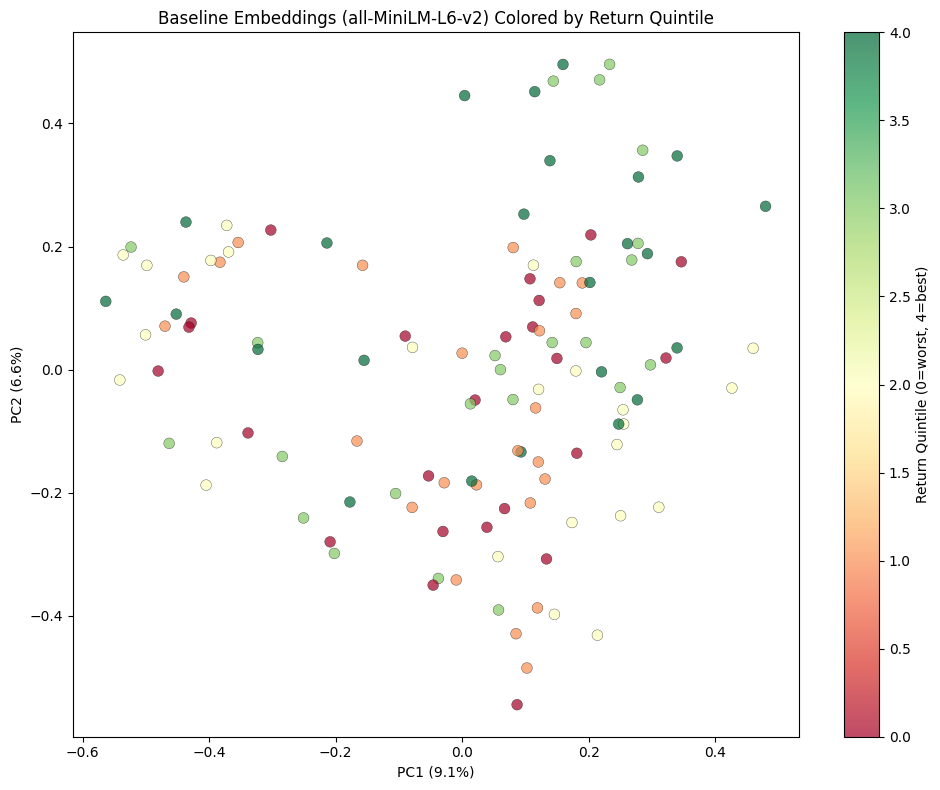

In [3]:
# Generate baseline embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
baseline_embeddings = model.encode(
    df["headline"].tolist(), show_progress_bar=True, convert_to_numpy=True
)
print(f"Baseline embedding shape: {baseline_embeddings.shape}")

# Visualize with PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(baseline_embeddings)

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=df["quintile"],
    cmap="RdYlGn",
    alpha=0.7,
    s=60,
    edgecolors="black",
    linewidth=0.3,
)
plt.colorbar(scatter, label="Return Quintile (0=worst, 4=best)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
ax.set_title("Baseline Embeddings (all-MiniLM-L6-v2) Colored by Return Quintile")
plt.tight_layout()
plt.show()

## 3. Contrastive Learning Setup
We use a simple contrastive loss: minimize distance between same-quintile pairs, maximize distance between different-quintile pairs.

In [5]:
class ContrastivePairDataset(Dataset):
    """Generate pairs for contrastive learning.
    Positive pairs: same return quintile
    Negative pairs: different return quintile
    """

    def __init__(self, embeddings, quintiles, n_pairs=1000):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.quintiles = np.array(quintiles)
        self.n_pairs = n_pairs

        # Pre-compute indices per quintile for efficient sampling
        self.quintile_indices = {}
        for q in range(5):
            self.quintile_indices[q] = np.where(self.quintiles == q)[0]

    def __len__(self):
        return self.n_pairs

    def __getitem__(self, idx):
        # 50% positive pairs, 50% negative pairs
        is_positive = np.random.random() > 0.5

        anchor_idx = np.random.randint(len(self.embeddings))
        anchor_q = self.quintiles[anchor_idx]

        if is_positive:
            # Same quintile
            pair_idx = np.random.choice(self.quintile_indices[anchor_q])
            label = 1.0
        else:
            # Different quintile (prefer distant quintiles)
            other_qs = [q for q in range(5) if q != anchor_q]
            pair_q = np.random.choice(other_qs)
            pair_idx = np.random.choice(self.quintile_indices[pair_q])
            label = 0.0

        return (
            self.embeddings[anchor_idx],
            self.embeddings[pair_idx],
            torch.tensor(label),
        )


class ProjectionHead(nn.Module):
    """Small projection head to fine-tune embedding space."""

    def __init__(self, input_dim=384, hidden_dim=128, output_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=-1)


class ContrastiveLoss(nn.Module):
    """Contrastive loss with cosine similarity."""

    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin

    def forward(self, emb1, emb2, label):
        similarity = F.cosine_similarity(emb1, emb2)
        # Positive pairs: maximize similarity
        # Negative pairs: minimize similarity (push below margin)
        loss_pos = label * (1 - similarity)
        loss_neg = (1 - label) * torch.clamp(similarity - self.margin, min=0)
        return (loss_pos + loss_neg).mean()


print("Contrastive learning components defined:")
print(
    "  - ContrastivePairDataset: generates positive/negative pairs from quintile labels"
)
print("  - ProjectionHead: 384 \u2192 128 \u2192 64 dimensional projection")
print("  - ContrastiveLoss: cosine similarity with margin")

Contrastive learning components defined:
  - ContrastivePairDataset: generates positive/negative pairs from quintile labels
  - ProjectionHead: 384 → 128 → 64 dimensional projection
  - ContrastiveLoss: cosine similarity with margin


## 4. Train the Projection Head

Epoch 5/20, Loss: 0.0649
Epoch 10/20, Loss: 0.0259
Epoch 15/20, Loss: 0.0002
Epoch 20/20, Loss: 0.0002


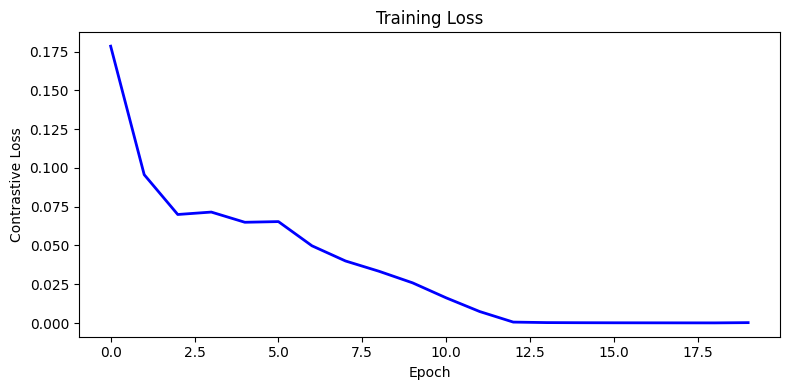

In [6]:
# Create dataset and dataloader
dataset = ContrastivePairDataset(
    baseline_embeddings, df["quintile"].values, n_pairs=5000
)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model
projection = ProjectionHead(input_dim=384, hidden_dim=128, output_dim=64)
criterion = ContrastiveLoss(margin=0.3)
optimizer = torch.optim.Adam(projection.parameters(), lr=1e-3)

# Training loop
losses = []
for epoch in range(20):
    epoch_loss = 0
    for emb1, emb2, labels in loader:
        proj1 = projection(emb1)
        proj2 = projection(emb2)
        loss = criterion(proj1, proj2, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/20, Loss: {avg_loss:.4f}")

# Plot training loss
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(losses, "b-", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Contrastive Loss")
ax.set_title("Training Loss")
plt.tight_layout()
plt.show()

## 5. Compare: Baseline vs Contrastive Embeddings

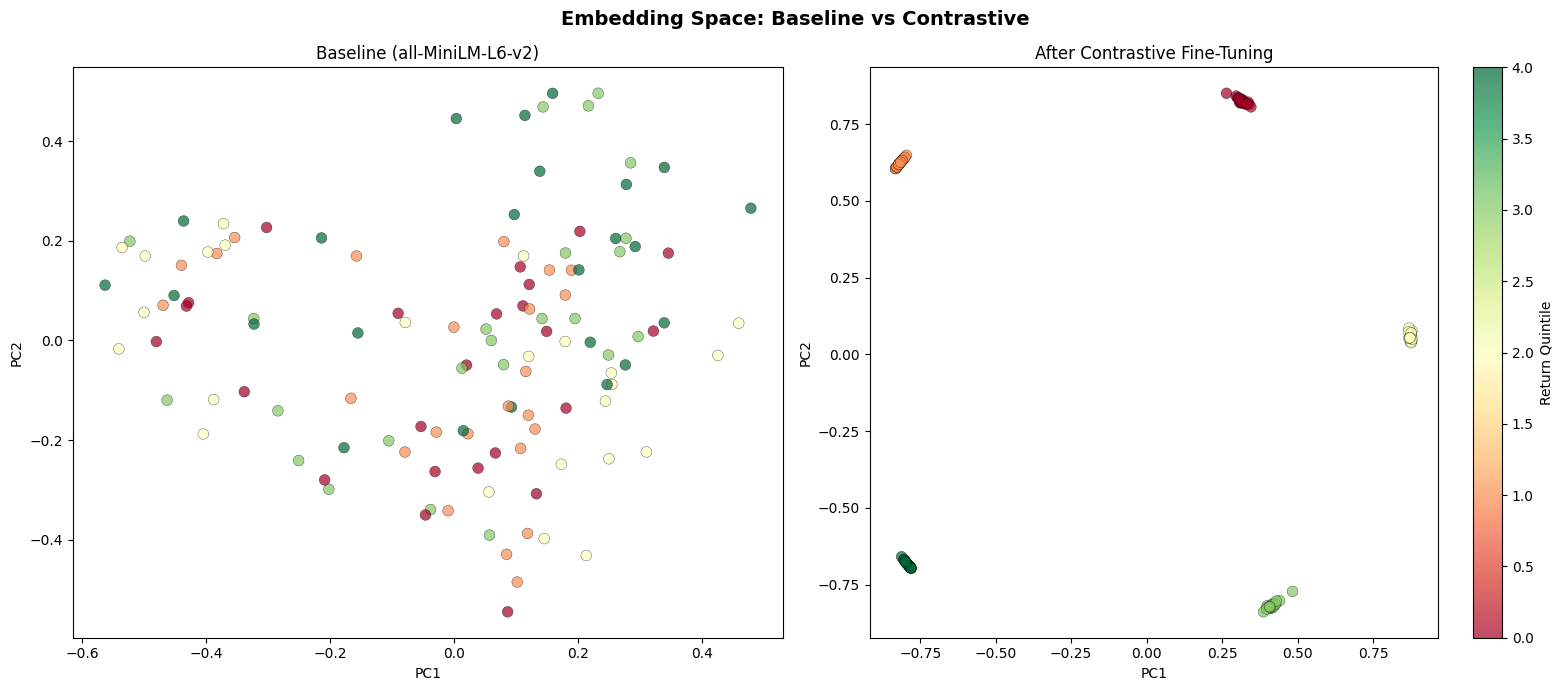

In [8]:
# Project embeddings through trained projection head
with torch.no_grad():
    contrastive_embeddings = projection(
        torch.tensor(baseline_embeddings, dtype=torch.float32)
    ).numpy()

# PCA for visualization
pca_baseline = PCA(n_components=2).fit_transform(baseline_embeddings)
pca_contrastive = PCA(n_components=2).fit_transform(contrastive_embeddings)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Baseline
sc1 = axes[0].scatter(
    pca_baseline[:, 0],
    pca_baseline[:, 1],
    c=df["quintile"],
    cmap="RdYlGn",
    alpha=0.7,
    s=60,
    edgecolors="black",
    linewidth=0.3,
)
axes[0].set_title("Baseline (all-MiniLM-L6-v2)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Contrastive
sc2 = axes[1].scatter(
    pca_contrastive[:, 0],
    pca_contrastive[:, 1],
    c=df["quintile"],
    cmap="RdYlGn",
    alpha=0.7,
    s=60,
    edgecolors="black",
    linewidth=0.3,
)
axes[1].set_title("After Contrastive Fine-Tuning")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.colorbar(sc2, ax=axes[1], label="Return Quintile")
plt.suptitle("Embedding Space: Baseline vs Contrastive", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 6. Quantitative Evaluation

Evaluation Metrics:
Metric                                Baseline  Contrastive
------------------------------------------------------------
Silhouette Score                       -0.0074       0.9754
Same-quintile avg similarity            0.2670       0.9994
Diff-quintile avg similarity            0.2323      -0.2398
Similarity gap (same - diff)            0.0347       1.2393


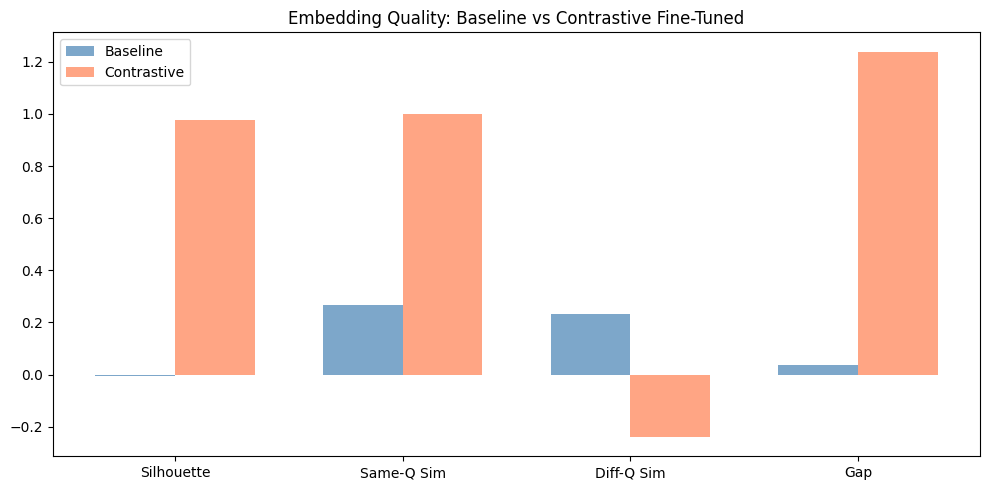

In [9]:
from sklearn.metrics import silhouette_score

# Silhouette score: how well do quintile labels match embedding clusters?
sil_baseline = silhouette_score(
    baseline_embeddings, df["quintile"], sample_size=min(300, len(df))
)
sil_contrastive = silhouette_score(
    contrastive_embeddings, df["quintile"], sample_size=min(300, len(df))
)


# Same-quintile vs different-quintile similarity
def avg_similarity_by_group(embeddings, labels):
    """Compute average cosine similarity for same-group and different-group pairs."""
    sim = cosine_similarity(embeddings)
    same_sims = []
    diff_sims = []
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:
                same_sims.append(sim[i, j])
            else:
                diff_sims.append(sim[i, j])
    return np.mean(same_sims), np.mean(diff_sims)


same_base, diff_base = avg_similarity_by_group(
    baseline_embeddings, df["quintile"].values
)
same_cont, diff_cont = avg_similarity_by_group(
    contrastive_embeddings, df["quintile"].values
)

print("Evaluation Metrics:")
print(f"{'Metric':<35} {'Baseline':>10} {'Contrastive':>12}")
print("-" * 60)
print(f"{'Silhouette Score':<35} {sil_baseline:>10.4f} {sil_contrastive:>12.4f}")
print(f"{'Same-quintile avg similarity':<35} {same_base:>10.4f} {same_cont:>12.4f}")
print(f"{'Diff-quintile avg similarity':<35} {diff_base:>10.4f} {diff_cont:>12.4f}")
print(
    f"{'Similarity gap (same - diff)':<35} {same_base - diff_base:>10.4f} {same_cont - diff_cont:>12.4f}"
)

# Bar chart comparison
fig, ax = plt.subplots(figsize=(10, 5))
metrics = ["Silhouette", "Same-Q Sim", "Diff-Q Sim", "Gap"]
baseline_vals = [sil_baseline, same_base, diff_base, same_base - diff_base]
contrastive_vals = [sil_contrastive, same_cont, diff_cont, same_cont - diff_cont]

x = np.arange(len(metrics))
width = 0.35
ax.bar(
    x - width / 2, baseline_vals, width, label="Baseline", color="steelblue", alpha=0.7
)
ax.bar(
    x + width / 2,
    contrastive_vals,
    width,
    label="Contrastive",
    color="coral",
    alpha=0.7,
)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title("Embedding Quality: Baseline vs Contrastive Fine-Tuned")
ax.legend()
plt.tight_layout()
plt.show()

## Discussion & Interview Talking Points

### Connection to My Experience
- **Creyon Bio**: Used contrastive learning on 3D electrostatic maps to predict oligo toxicity. Pushed AUC from 0.73 to 0.88.
- **Same framework**: Instead of electrostatic maps → toxicity, we have financial text → returns. The contrastive objective is identical.
- **DPO experience**: My recent DPO fine-tuning work (Qwen 32B) uses a similar preference-based optimization — DPO is conceptually a contrastive method.

### Strengths
- **Domain-adapted**: Embeddings are optimized for the actual downstream task (return prediction)
- **Beyond sentiment**: Captures whatever textual patterns correlate with returns, not just positive/negative
- **Composable**: Can use contrastive embeddings as input to any downstream model

### Weaknesses & Considerations
- **Requires labeled data**: Need (text, return) pairs, which means historical market data
- **Temporal leakage risk**: Must use strict temporal train/test splits
- **Overfitting**: With small datasets, the projection head can memorize rather than generalize

### For Numerai
- Contrastive embeddings trained on returns that have been **factor-neutralized** would directly optimize for Numerai's scoring metric
- Could combine with graph features (NB04): contrastive loss where graph-neighbors should have similar embeddings

### Extensions (TODO)
- [ ] Use triplet loss instead of pairwise contrastive
- [ ] Fine-tune the encoder itself (not just a projection head) with LoRA
- [ ] Train on factor-neutralized returns for Numerai-specific optimization
- [ ] Add hard negative mining (most confusing cross-quintile pairs)
- [ ] Compare InfoNCE, NT-Xent, and supervised contrastive losses